# Analyze Region 10 - Asia, North

This notebook analyzes the largest glaciers, ice caps, and ice fields in Region 10 - Asia, North.

This region was deemed as needing a glacier complex analysis (ice caps and icefields), so note that the abbreviation "ic" stands for ice catchment aka glacier complex.

In [1]:
import os
import os.path as op
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "10"
region_name = "Asia, North"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
primeclass = 6 # This was not already set in GLIMS but based it on what the WGI said

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 9
region_index_2 = 10

# Ice cap/icefield epsg code used for calculating area
ic_epsg = '102025'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

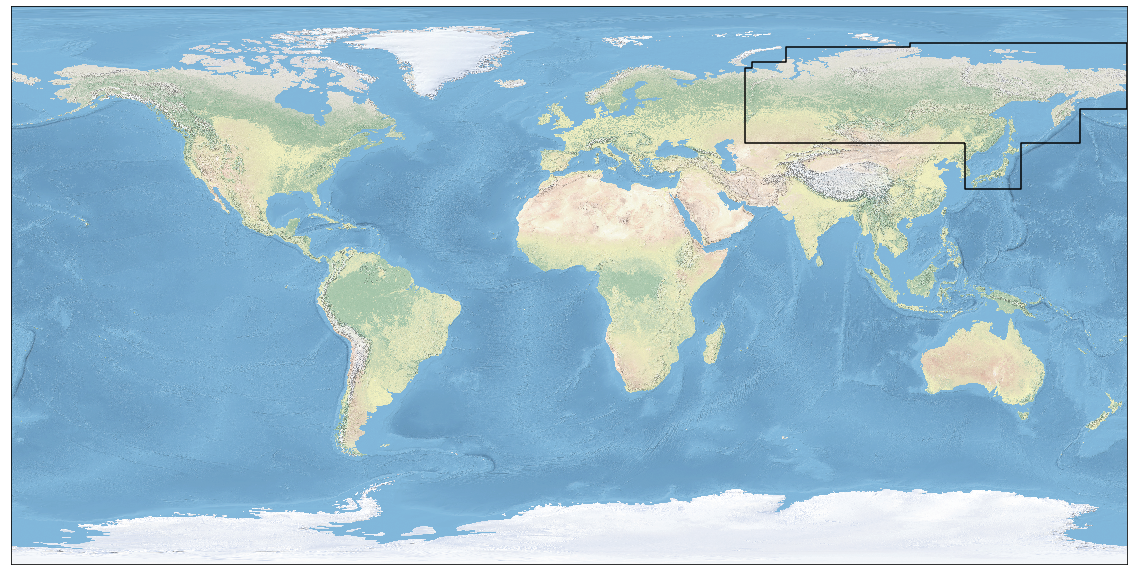

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx  miny   maxx  maxy
9  57.0  31.0  180.0  78.0

# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

region_no         glac_id    area  db_area  width  length  primeclass  \
0         10  G148920E76680N  48.144  48.1442    0.0     0.0         0.0   
1         10  G087851E49154N  37.323  37.3957    0.0     0.0         0.0   
2         10  G160564E57830N  33.714  33.7142    0.0     0.0         0.0   
3         10  G160561E56087N  33.481  33.4809    0.0     0.0         0.0   
4         10  G087783E49100N  23.955  23.9553    0.0     0.0         0.0   

   min_elev  mean_elev  max_elev             src_date  \
0      40.0        0.0     380.0  1956-05-15T00:00:00   
1    2913.0        0.0    4317.0  2011-08-23T00:00:00   
2     946.0        0.0    1908.0  2011-08-03T00:00:00   
3    1103.0        0.0    3852.0  2011-08-03T00:00:00   
4    2507.0        0.0    4319.0  2011-08-23T00:00:00   

                                          glac_name  \
0  SU5E17701002 Toll Ice Cap                      ?   
1                                              None   
2                                              None   
3                                              None   
4                                    Kanasi Glacier   

                                            geometry  
0  POLYGON Z ((149.07254 76.67994899999999 0, 149...  
1  POLYGON Z ((87.823842 49.178093 0, 87.82388400...  
2  POLYGON Z ((160.561655 57.84762 0, 160.561149 ...  
3  POLYGON Z ((160.513231 56.097518 0, 160.513263...  
4  POLYGON Z ((87.827422 49.135559 0, 87.82906699...

## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

RGI glacier 1 equals none
RGI glacier 2 equals none
RGI glacier 3 equals none
RGI glacier 4 equals none


In [12]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate      CenLon     CenLat  \
0  RGI60-10.00002  G148920E76680N  19560599  19560999  148.920000  76.680000   
1  RGI60-10.02000  G087857E49157N  20110823  -9999999   87.856636  49.156937   
2  RGI60-10.04181  G160564E57830N  20110803  -9999999  160.564331  57.830070   
3  RGI60-10.04024  G160561E56087N  20110803  -9999999  160.561066  56.086594   
4  RGI60-10.01997  G087840E49109N  20110823  -9999999   87.839622  49.108753   

  O1Region O2Region    Area  Zmin  ...  Aspect   Lmax  Status  Connect  Form  \
0       10        2  48.144     0  ...     185   4900       2        0     1   
1       10        4  37.323  2915  ...      75  12001       0        0     0   
2       10        5  33.714   946  ...     254   9205       0        0     0   
3       10        5  33.481  1103  ...      43  21922       0        0     0   
4       10        4  23.955  2507  ...     328   9990       0        0     0   

   TermType  Surging  Linkages                       Name  \
0         0        9         0  SU5E17701002 Toll Ice Cap   
1         0        9         9                       NONE   
2         0        9         9                       NONE   
3         0        9         9                       NONE   
4         0        9         9                       NONE   

                                            geometry  
0  POLYGON ((148.9464210090001 76.64537134700004,...  
1  POLYGON ((87.84088046800008 49.17746101500006,...  
2  POLYGON ((160.5616545920001 57.84761960300006,...  
3  POLYGON ((160.647832844 56.09387418000006, 160...  
4  POLYGON ((87.83897694500007 49.13412628400005,...  

[5 rows x 23 columns]

## Plot GLIMS Glaciers

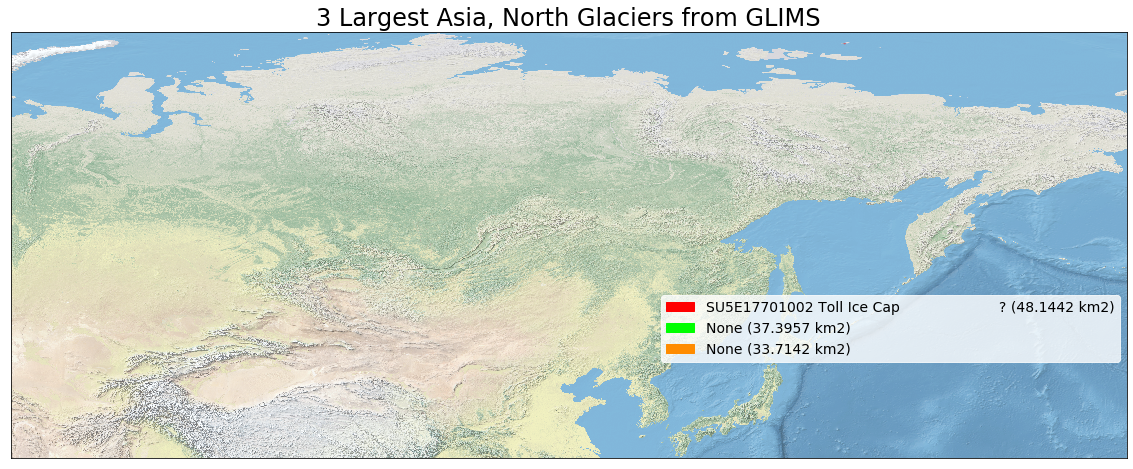

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

## Plot RGI Glaciers

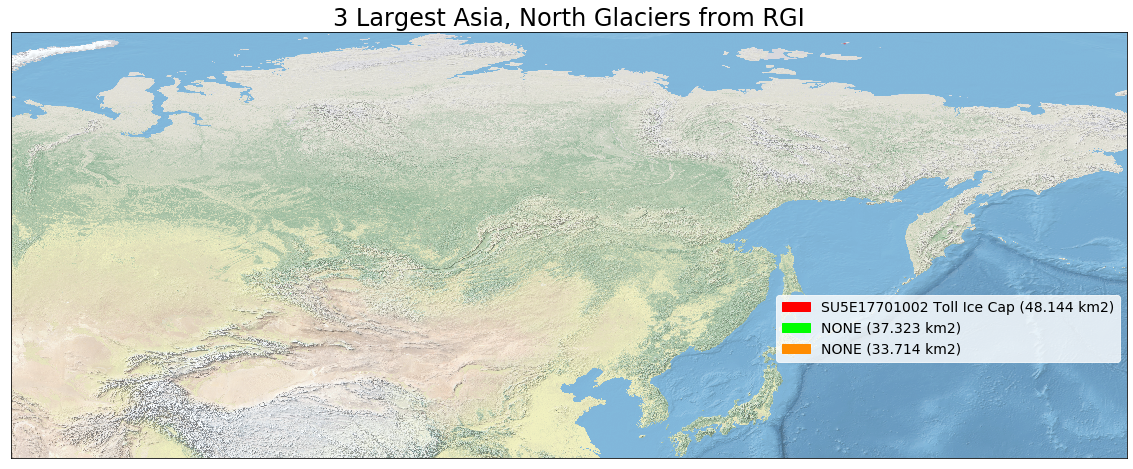

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0, 0.4))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate. Once the differences have been investigated and corrected in the code below this code block, set handled to 1 in the "Set Up Region Info" section at the top of the notebook, so that it passes this test.

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create Final Glacier Shapefiles
This section creates and formats the final glacier dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

Since the largest glacier in the GLIMS and RGI databases is actually an ice cap (Toll), skipping that one and using the next 3 entries as the the 3 largest glaciers.

Check WGI for primary classification

Locations of these glaciers:
* Toll Ice Cap (G148920E76680N) - Located on Bennett Island, which is the far northeast corner of Russian mainland (Kotlyakov, 2010)
* G087851E49154N - Potanin Glacier (Kamp et al., 2013) located in Mongolia at the corner where Mongolia meets China, Russia, and Kazakhstan in the Tavan Bogd Massif in the Mongol-Altai Mountains. No entry for this in WGI, I'm calling it a primary class of 6.
* G160564E57830N - Slunina Glacier (Khromova et al., 2014) located on Kamchatka Peninsula in very far northwest Russia in the Sredinny Range. WGI says primary class is 6 (SU5F20004085). 
* G160561E56087N - No name (Muraviev, 2016) located on Kamchatka Peninsula in very far northwest Russia on Ushkovsky volcano. WGI doesn't exactly have an entry for this but a small area off to the side of the glacier (SU5F20003158) says primary class of 5. I think it's more likely a 6.

### Create final glacier dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_glacier_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                                'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_glacier_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_glacier_data_df['primeclass'] = primeclass

# Reorder the columns of the dataframe
final_glacier_data_df = final_glacier_data_df[['region_no', 'reg_name', 'glac_name', 'glac_id', 
                               'primeclass', 'db_area', 'src_date', 'geometry']]

# Rename some columns
final_glacier_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop first and last rows because the first row is an ice cap and the last row is the 4th largest glacier so we
# aren't interested in them
final_glacier_data_df.drop([0, 4], inplace = True)

In [17]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note only comparing by year because sometimes the month and day are not known. Year matching is close enough.
# Since skipping the first entry in both GLIMS and RGI because it is an ice cap, adding a 1 to the index
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_glaciers_df['src_date'][x+1][0:10].replace('-', '')
    glims_year = glims_date[0:4]
    print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    rgi_date = rgi_glaciers_df['BgnDate'][x+1]
    rgi_year = rgi_date[0:4]
    print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    if glims_year == rgi_year:
        # Average GLIMS and RGI areas
        area = np.average([glims_glaciers_df['db_area'][x+1], rgi_glaciers_df['Area'][x+1]])
        print('Averaging area: ' + str(area))
    elif glims_year > rgi_year:
        # Use GLIMS area for the area
        area = glims_glaciers_df['db_area'][x+1]
        print('Using GLIMS area: ' + str(area))
    elif rgi_year > glims_year:
        # Use RGI area for the area
        area = rgi_glaciers_df['Area'][x+1]
        print('Using RGI area: ' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('area_km2')] = area
    
    # Clean the date format in the final dataframe
    final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x+1][0:10]
    
    # Use the glacier names from RGI for the final data df
    if x == 0:
        # Simply set the final df name to the rgi name
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = "Potanin Glacier"
    if x == 1:
        # Clean up the Devon Ice Cap Southeast glacier name
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = "Slunina Glacier"
    if x == 2:
        # Set this name to Crocker Bay Glacier per Wyatt and Sharp(2015)
        final_glacier_data_df.iloc[x, final_glacier_data_df.columns.get_loc('glac_name')] = "Unnamed Glacier"
        
# Reset index
final_glacier_data_df = final_glacier_data_df.reset_index(drop=True)

glims date: 20110823
rgi date: 20110823
Averaging area: 37.35935

glims date: 20110803
rgi date: 20110803
Averaging area: 33.7141

glims date: 20110803
rgi date: 20110803
Averaging area: 33.48095



In [18]:
final_glacier_data_df

region_no     reg_name        glac_name        glims_id  primeclass  \
0         10  Asia, North  Potanin Glacier  G087851E49154N           6   
1         10  Asia, North  Slunina Glacier  G160564E57830N           6   
2         10  Asia, North  Unnamed Glacier  G160561E56087N           6   

   area_km2        date                                           geometry  
0  37.35935  2011-08-23  POLYGON Z ((87.823842 49.178093 0, 87.82388400...  
1  33.71410  2011-08-03  POLYGON Z ((160.561655 57.84762 0, 160.561149 ...  
2  33.48095  2011-08-03  POLYGON Z ((160.513231 56.097518 0, 160.513263...

### Plot final glacier dataframe to check accuracy

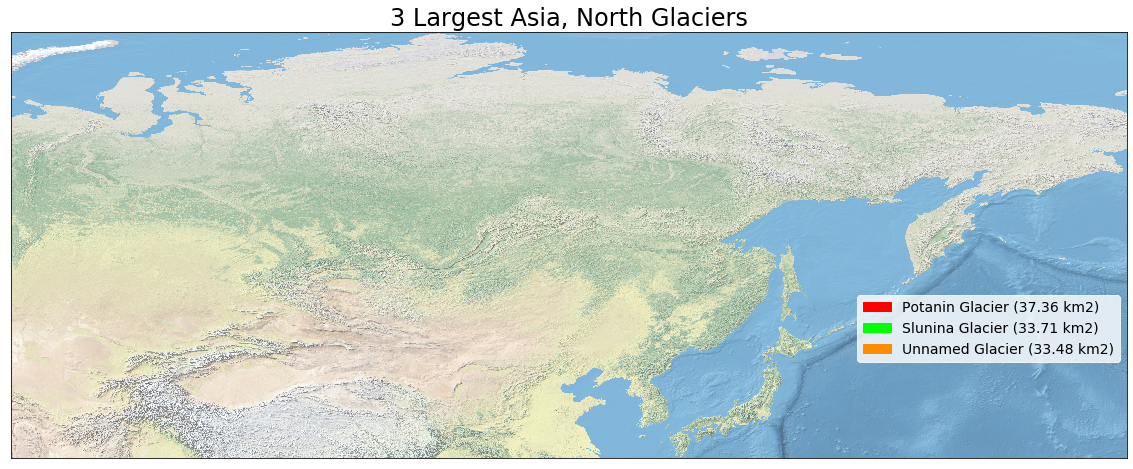

In [19]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_glacier_data_df['glac_name'][0] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][0], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][1] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][1], 2)) + ' km2)',
                 final_glacier_data_df['glac_name'][2] + \
                 ' (' + str(round(final_glacier_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_glacier_data_df.iloc[0:1].plot(ax=ax, color='red')
final_glacier_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_glacier_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,0.4))

plt.show()

### Create largest glacier shapefile from the final glacier dataframe

In [20]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
glacier_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(glacier_zipfile_fn) == False:
    # Create the shapefile
    final_glacier_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_glacier_data_df.to_file(driver='ESRI Shapefile', filename=final_glacier_data_fn)
    
    # Zip up the shapefile
    glacier_zipfile_fn = ws.zipshp(final_glacier_data_fn, Delete=True)
    print("Creating zipfile: " + glacier_zipfile_fn)
else:
    print(glacier_zipfile_fn + " already extists")

data/final-dataset/region-10-largest-glaciers.zip already extists


# * * * * * * * * Ice Cap Analysis * * * * * * * *

This region really only has one ice cap (Toll Ice Cap) but the following code reveals some ice fields.

In [21]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                  region_number + "_esri" + ic_epsg + ".shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [22]:
ice_caps_ex_df

id        area                                           geometry
0     9  136.988806  POLYGON ((87.95810299999999 49.065968, 87.9580...
1    50  123.043004  POLYGON ((160.613763 56.033431, 160.613752 56....
2    65  114.397785  POLYGON ((160.817577 58.130983, 160.817563 58....
3   118   86.023892  POLYGON ((87.70047 50.02068, 87.700137 50.0206...
4    43   84.429953  POLYGON ((86.55569800000001 49.772083, 86.5561...
5    10   68.513711  POLYGON ((87.310936 49.082513, 87.310934 49.08...
6  2521   61.590652  POLYGON ((87.78063400000001 49.767304, 87.7806...
7  5211   48.801539  POLYGON ((149.0384 76.64999400000001, 149.0381...
8    63   43.104507  POLYGON ((160.788032 58.00904, 160.787965 58.0...
9    72   38.566371  POLYGON ((160.625996 57.850854, 160.625923 57....

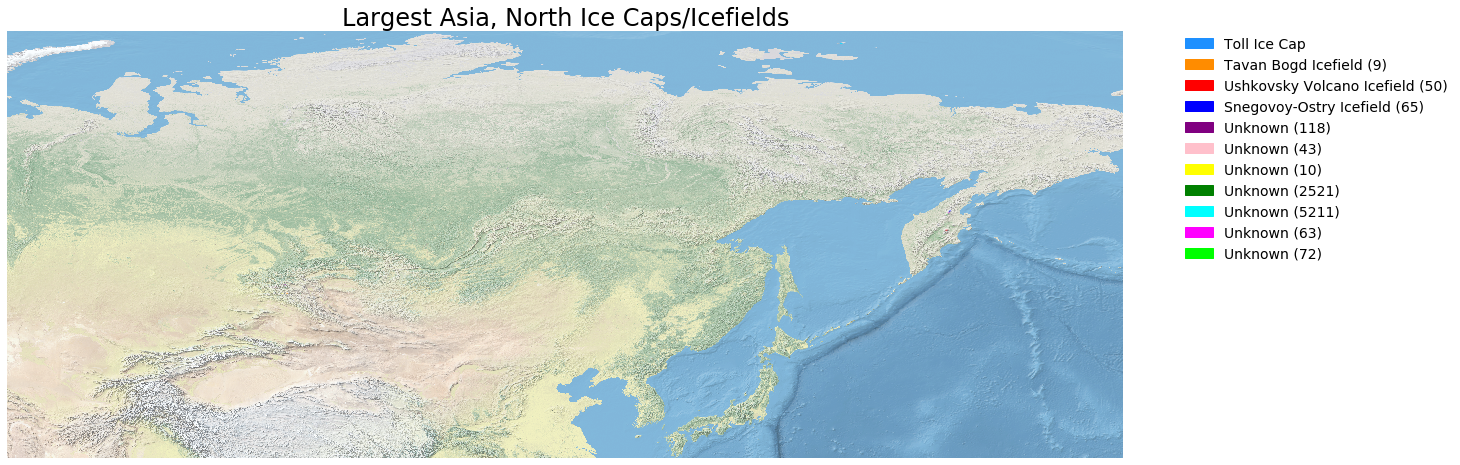

In [23]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['dodgerblue', 'darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = ['Toll Ice Cap', 'Tavan Bogd Icefield (9)', 'Ushkovsky Volcano Icefield (50)', 
                 'Snegovoy-Ostry Icefield (65)', 
                 'Unknown (118)', 'Unknown (43)', 'Unknown (10)', 'Unknown (2521)', 
                 'Unknown (5211)', 'Unknown (63)', 'Unknown (72)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
# Adding Toll Ice Cap from GLIMS
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='dodgerblue')
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

In [24]:
# Stop notebook and examine ice caps and icefields. 
# Comment this out when not needed.
#class StopExecution(Exception):
#    def _render_traceback_(self):
#        pass

#print("Stopping notebook to examine glacier complexes.")
#raise StopExecution

## Create Final Ice Catchment Data Frame
This ice catchment data frame will then be saved to a shapefile.

Since Toll Ice Cap is the only one in this region, simpy adding it to the catchemnt data frame from the GLIMS database, since GLIMS and RGI match. Toll Ice Cap is on Bennet Island north of the Russian mainland.

For the icefields, these don't really have names, so will need to ask correspondant how they feel about the names I'm giving them and if these are really icefields.

The top 3 icefields in ice_caps_ex_df:

* ID 9 - "Tavan Bogd Icefield" located in Mongolia at the corner where Mongolia meets China, Russia, and Kazakhstan in the Tavan Bogd Massif in the Mongol-Altai Mountains.
* ID 50 - "Ushkovsky Volcano Icefield" located on Kamchatka Peninsula
* ID 65 - "Snegovoy-Ostry Icefield" located on Kamchatka Peninsula

In [25]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps and icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add Toll Ice Cap from GLIMS database
final_catchment_data_df = final_catchment_data_df.append(glims_glaciers_df.iloc[0:1].drop(['region_no',
                                                                                           'glac_id', 
                                                                                           'db_area', 
                                                                                           'width',
                                                                                           'length',
                                                                                           'primeclass',
                                                                                           'min_elev',
                                                                                           'max_elev',
                                                                                           'mean_elev',
                                                                                           'src_date',
                                                                                           'glac_name'], axis=1))


# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_catchment_data_df['primeclass'] = [2, 2, 2, 3]

# Add catchment names
final_catchment_data_df['ic_name'] = ['Tavan Bogd Icefield', 'Ushkovsky Volcano Icefield', 
                                      'Snegovoy-Ostry Icefield', 'Toll Ice Cap']

### Get ice catchment measurement dates from a range of glacier outline dates.

In [26]:
# Open GLIMS shapefile with all of the glacier outlines
glims_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [27]:
# Get glaciers on Tavan Bogd Icefield
tavan_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True))
tavan_glaciers = glims_all_glaciers_df.loc[tavan_ic_mask]

# Print the minimum date and the maximum date
tavan_glaciers_min_date = tavan_glaciers['src_date'].min()[0:10]
tavan_glaciers_max_date = tavan_glaciers['src_date'].max()[0:10]
print('tavan start date: ' + tavan_glaciers_min_date)
print('tavan end date: ' + tavan_glaciers_max_date)
print('')

# Get glaciers on Ushkovsky Volcano Icefield
ushkov_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True))
ushkov_glaciers = glims_all_glaciers_df.loc[ushkov_ic_mask]

# Print the minimum date and the maximum date
ushkov_glaciers_min_date = ushkov_glaciers['src_date'].min()[0:10]
ushkov_glaciers_max_date = ushkov_glaciers['src_date'].max()[0:10]
print('ushkov start date: ' + ushkov_glaciers_min_date)
print('ushkov end date: ' + ushkov_glaciers_max_date)
print('')

# Get glaciers on Snegovoy-Ostry Icefield
so_ic_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True))
so_glaciers = glims_all_glaciers_df.loc[so_ic_mask]

# Print the minimum date and the maximum date
so_glaciers_min_date = so_glaciers['src_date'].min()[0:10]
so_glaciers_max_date = so_glaciers['src_date'].max()[0:10]
print('Snegovoy start date: ' + so_glaciers_min_date)
print('Snegovoy end date: ' + so_glaciers_max_date)
print('')

# Set Toll Ice Cap min and max date to same date as GLIMS
toll_glaciers_min_date = glims_date = glims_glaciers_df['src_date'][0][0:10]
toll_glaciers_max_date = glims_date = glims_glaciers_df['src_date'][0][0:10]
print('toll start date: ' + toll_glaciers_min_date)
print('toll end date: ' + toll_glaciers_max_date)
print('')

tavan start date: 1989-09-03
tavan end date: 2011-08-23

ushkov start date: 2011-08-03
ushkov end date: 2011-08-03

Snegovoy start date: 2000-07-18
Snegovoy end date: 2000-07-18

toll start date: 1956-05-15
toll end date: 1956-05-15



In [28]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [tavan_glaciers_min_date, ushkov_glaciers_min_date, 
                                       so_glaciers_min_date, toll_glaciers_min_date]

final_catchment_data_df['max_date'] = [tavan_glaciers_max_date, ushkov_glaciers_max_date, 
                                       so_glaciers_max_date, toll_glaciers_max_date]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 'min_date', 
                                                   'max_date', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [29]:
final_catchment_data_df

region_no     reg_name                     ic_name  primeclass    area_km2  \
0        10  Asia, North         Tavan Bogd Icefield           2  136.988806   
1        10  Asia, North  Ushkovsky Volcano Icefield           2  123.043004   
2        10  Asia, North     Snegovoy-Ostry Icefield           2  114.397785   
3        10  Asia, North                Toll Ice Cap           3   48.144000   

     min_date    max_date                                           geometry  
0  1989-09-03  2011-08-23  POLYGON ((87.95810299999999 49.065968, 87.9580...  
1  2011-08-03  2011-08-03  POLYGON ((160.613763 56.033431, 160.613752 56....  
2  2000-07-18  2000-07-18  POLYGON ((160.817577 58.130983, 160.817563 58....  
3  1956-05-15  1956-05-15  POLYGON Z ((149.07254 76.67994899999999 0, 149...

### Plot the final catchment dataframe to verify it looks correct

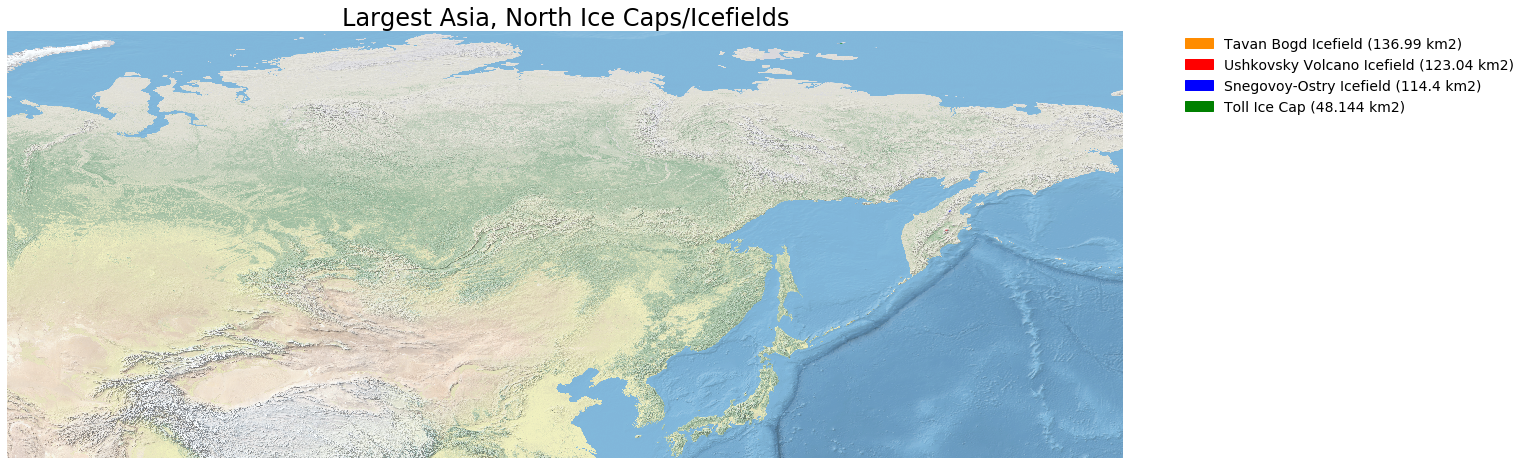

In [30]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'green']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)',
                 final_catchment_data_df['ic_name'][3] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][3], 3)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="darkorange")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="red")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="blue")
final_catchment_data_df.iloc[3:4].plot(ax=ax, color="green")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [31]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-10-largest-complexes.zip
